# Библиотеки

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from catboost import CatBoostClassifier, CatBoostRegressor

# Предобработка

Считывание и построения дерева XML файла

In [2]:
soup = BeautifulSoup(open('data/fantasy1984.xml', mode='r', encoding='utf-8'), 'xml')

Список уникальных тегов

In [3]:
set([tag.name for tag in soup.findChildren()])

{'FirstSentence',
 'LastSentence',
 'allophone',
 'content',
 'dictitem',
 'intonation',
 'letter',
 'pause',
 'phoneme',
 'sentence',
 'stress',
 'text',
 'word'}

Посмотрим на строение предложения

In [4]:
print(soup.find('sentence').prettify())

<sentence>
 <FirstSentence/>
 <content LinkType="5"/>
 <word original="Джордж">
  д
  <letter char="д" flag="16"/>
  <phoneme ph="д"/>
  <allophone En="|15|259|505|" FO1="110" FO_INIT="113" OtN="1" Rm="83" features="|0|0|100|26746|12399|1|6|0|0|1|2|0|6|1|1|1|1|4|0|1|12399|0|1|1|0|1|3|1|2|0|0|0|0|0|1|4|0|2|0|3|0|0|0|0|0|4|2|1|" mfcc="|-1.7685820252796953|0.60901793546686522|0.28858146714375998|1.1232094909726225|0.42976699249584555|0.13687468256946028|0.029959628369140064|0.020765333618609307|0.5670538369454855|-0.16939669125809848|-0.38902210589070868|0.57138741486525779|" ph="d" spread="normal"/>
  ж
  <letter char="ж"/>
  <phoneme ph="ж"/>
  <allophone En="|859|1173|1914|" FO1="147" FO_INIT="114" OtN="1" Rm="79" features="|0|100|26746|12399|114|2|5|0|0|1|2|0|6|1|1|1|1|4|0|1|12399|0|1|1|0|1|3|1|2|0|0|0|0|0|1|4|0|2|0|3|0|0|0|0|0|4|2|1|" mfcc="|-0.26872450469927589|-1.2220246493271909|-0.3082533149013913|0.64912605727326|0.65045858522585842|0.51214372758243831|-0.10585595947707456|-0.05

Обработка и получение признаков

In [5]:
def get_features(xml_filename: str = None, csv_filename: str = None):
    soup = BeautifulSoup(open(xml_filename, mode='r', encoding='utf-8'), 'xml')
    
    original = []
    lenWord = []
    wordForm = []
    # Знаки препинания и эмфазы на слове
    punktEnd = []
    punktBeg = []
    emphEnd = []
    emphBeg = []
    # Паузы
    isPause = []
    lenPause = []
    # Слова
    nucleus = []
    semantics1 = []
    semantics2 = []
    countBeforeWords = []
    countAfterWords = []
    beforeWords = []
    afterWords = []
    capitalized = []
    indexInSentence = []
    subpartOfSpeech = []

    for sentence in soup.find_all('sentence'):
        for i, el in enumerate(sentence.findChildren()):
            if el.name == 'content':
                if el.get('PauseType'):
                    isPause.append(1)
                else:
                    isPause.append(0)

                punktBeg.append(el.get('PunktBeg'))
                punktEnd.append(el.get('PunktEnd'))
                emphEnd.append(el.get('EmphEnd'))
                emphBeg.append(el.get('EmphBeg'))

            if el.name == 'pause':
                lenPause.append(int(el.get('time')))

            if el.name == 'word':
                lenWord.append(len(el.get('original')) if el.get('original') else 0)
                original.append(el.get('original'))
                nucleus.append(el.get('nucleus'))
                wordForm.append(int(el.find('dictitem').get('form')))
                semantics1.append(el.find('dictitem').get('semantics1'))
                semantics2.append(el.find('dictitem').get('semantics2'))
                subpartOfSpeech.append(el.find('dictitem').get('subpart_of_speech'))

                indexInSentence.append(i)

                if original[-1]:
                    capitalized.append(original[-1] == original[-1].lower().capitalize())
                else:
                    capitalized.append(None)



    for i, v in enumerate(original):
        countAfterWords.append(len(original) - i)
        countBeforeWords.append(i)

        if i == 0:
            beforeWords.append(None)
        else:
            beforeWords.append(original[i - 1])

        if i == len(original) - 1:
            afterWords.append(None)
        else:
            afterWords.append(original[i + 1])

    # Ставим метки длины пауз
    pauses = 0
    newLenPause = []
    for i in range(len(isPause)):
        if isPause[i]:
            newLenPause.append(lenPause[pauses])
            pauses += 1
        else:
            newLenPause.append(-1)
    lenPause = newLenPause

    # Переводим данные в pandas.DataFrame

    df = pd.DataFrame()

    df['original'] = original
    df['lenWord'] = lenWord
    df['wordForm'] = wordForm
    # Знаки препинания и эмфазы на слове
    df['punktEnd'] = punktEnd
    df['punktBeg'] = punktBeg
    df['emphEnd'] = emphEnd
    df['emphBeg'] = emphBeg
    # Паузы
    df['isPause'] = isPause
    df['lenPause'] = lenPause
    # Слова
    df['nucleus'] = nucleus
    df['semantics1'] = semantics1
    df['semantics2'] = semantics2
    df['countBeforeWords'] = countBeforeWords
    df['countAfterWords'] = countAfterWords
    df['beforeWords'] = beforeWords
    df['afterWords'] = afterWords
    df['capitalized'] = capitalized
    df['indexInSentence'] = indexInSentence
    df['subpartOfSpeech'] = subpartOfSpeech
    df['nucleus_labels'] = [el == '2' for el in nucleus]

    df = df.fillna('None') # Заполняем пустые места строкой

    df.to_csv(csv_filename)

    return df

In [6]:
df = get_features(xml_filename='data/fantasy1984.xml', csv_filename='markup/df.csv')

Смотрим на распределения данных

array([[<Axes: title={'center': 'lenWord'}>,
        <Axes: title={'center': 'wordForm'}>,
        <Axes: title={'center': 'isPause'}>],
       [<Axes: title={'center': 'lenPause'}>,
        <Axes: title={'center': 'countBeforeWords'}>,
        <Axes: title={'center': 'countAfterWords'}>],
       [<Axes: title={'center': 'indexInSentence'}>, <Axes: >, <Axes: >]],
      dtype=object)

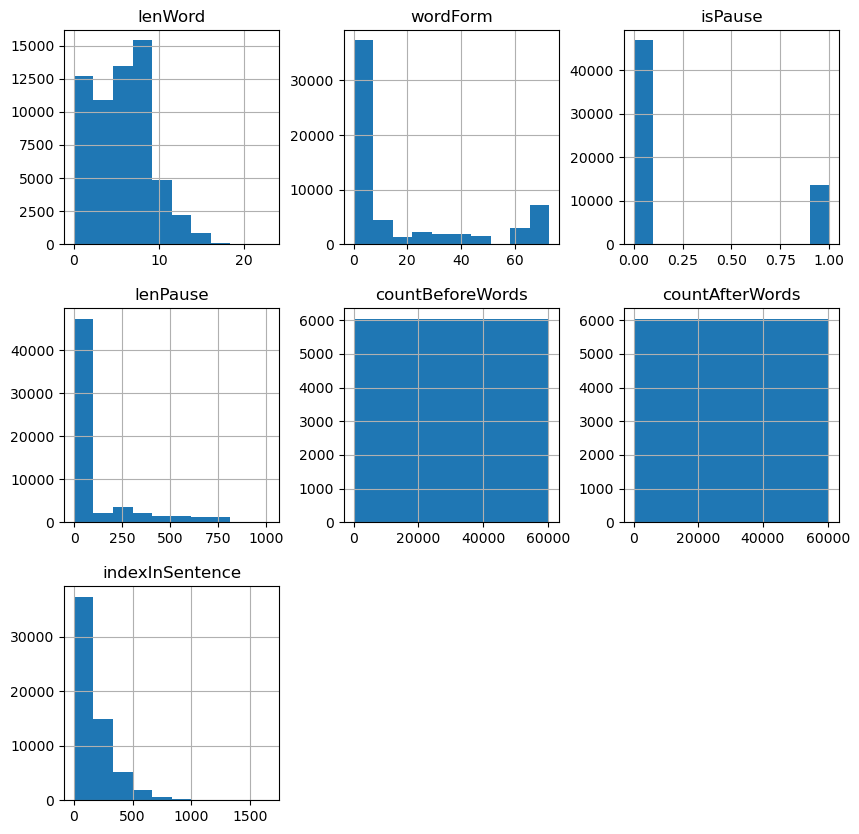

In [7]:
df.hist(figsize=(10, 10))

Сделаем обработку для второго файла (а данном случае Алые Паруса)

In [8]:
df_val = get_features(xml_filename='data/AlyieParusa.xml', csv_filename='markup/df_test.csv')

Распределения для текста Алые Паруса

array([[<Axes: title={'center': 'lenWord'}>,
        <Axes: title={'center': 'wordForm'}>,
        <Axes: title={'center': 'isPause'}>],
       [<Axes: title={'center': 'lenPause'}>,
        <Axes: title={'center': 'countBeforeWords'}>,
        <Axes: title={'center': 'countAfterWords'}>],
       [<Axes: title={'center': 'indexInSentence'}>, <Axes: >, <Axes: >]],
      dtype=object)

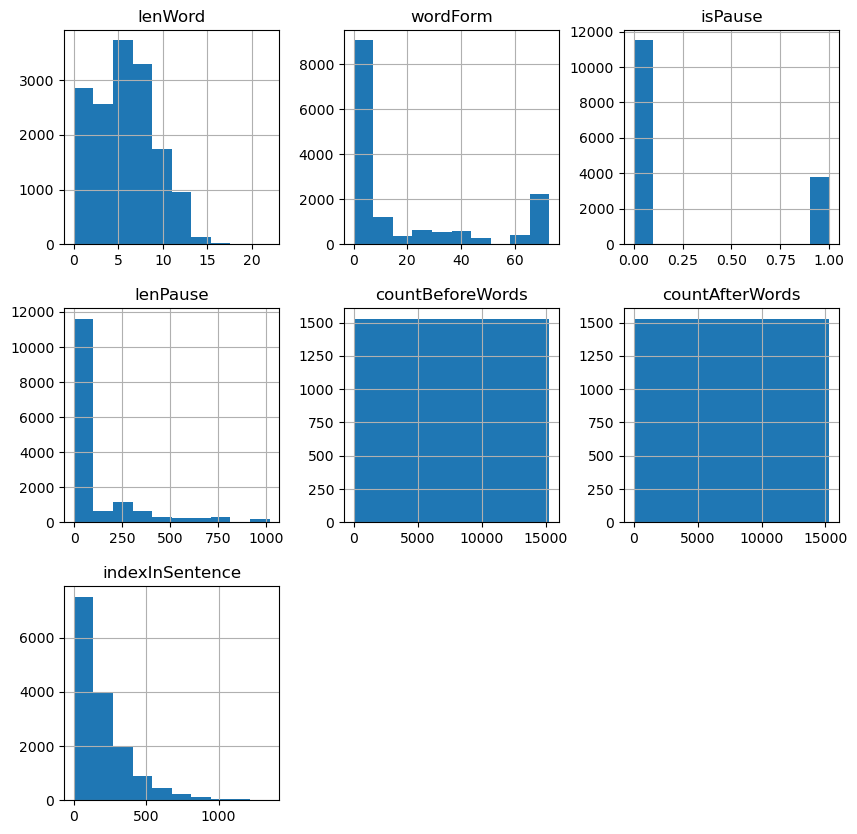

In [9]:
df_val.hist(figsize=(10, 10))

# Обучение классификтора для определения паузы и регрессора для определения длины паузы

Объединим оба файла в один, для проведения окончательного обучения

In [10]:
df_cat = pd.concat([df, df_val], ignore_index=True)

In [11]:
class Classifier:
    def __init__(self, df_train: pd.DataFrame = None, df_val: pd.DataFrame = None, categorical_features: list[str] = None, save_path: str = None) -> None:
        self.df_train = df_train[categorical_features]
        self.df_val = df_val[categorical_features]
        self.save_path = save_path

        self.cls = CatBoostClassifier(
            iterations=100,
            cat_features=categorical_features,
            custom_metric=['Accuracy', 'Precision', 'Recall', 'F1'],
            random_seed=42
        )
    
    def fit(self, labels: pd.DataFrame = None, labels_val: pd.DataFrame = None) -> None:
        self.cls.fit(X=self.df_train,
                     y=labels,
                     eval_set=(self.df_val, labels_val),
                     plot=True,
                     verbose=False
                    )
        self.cls.save_model(self.save_path)

In [12]:
class Regressor:
    def __init__(self, df_train: pd.DataFrame = None, df_val: pd.DataFrame = None, categorical_features: list[str] = None, save_path: str = None) -> None:
        self.df_train = df_train[categorical_features]
        self.df_val = df_val[categorical_features]
        self.save_path = save_path

        self.reg = CatBoostRegressor(
            iterations=100,
            cat_features=categorical_features,
            custom_metric=['RMSE', 'R2'],
            random_seed=42
        )
    
    def fit(self, labels: pd.DataFrame = None, labels_val: pd.DataFrame = None) -> None:
        self.reg.fit(X=self.df_train,
                     y=labels,
                     eval_set=(self.df_val, labels_val),
                     plot=True,
                     verbose=False
                    )
        self.reg.save_model(self.save_path)
        
        

Обучение классификатора для определения фразового ударения и наличия пауз

In [13]:
categorical_features_names = ['original', 'lenWord', 'wordForm', 'punktEnd', 'punktBeg', 'emphEnd', 'emphBeg', 'nucleus', 'semantics1', 
                              'semantics2', 'countBeforeWords', 'countAfterWords', 'beforeWords', 'afterWords', 'capitalized', 
                              'indexInSentence', 'subpartOfSpeech']

cls = Classifier(df_train=df, df_val=df_val, categorical_features=categorical_features_names, save_path='models/isPause.cbm')

cls.fit(labels=df['isPause'], labels_val=df_val['isPause'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

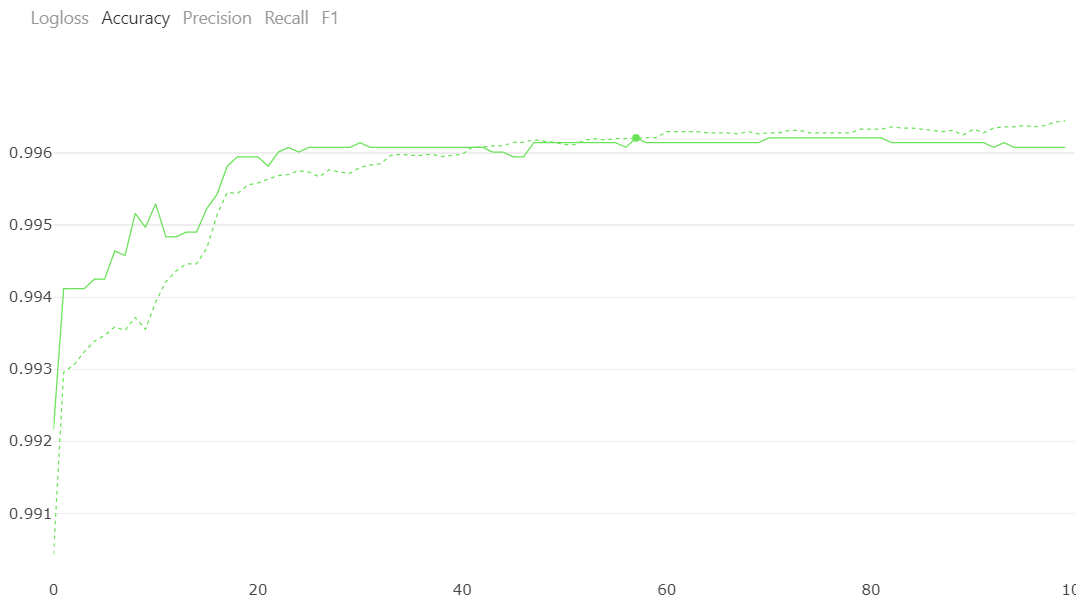
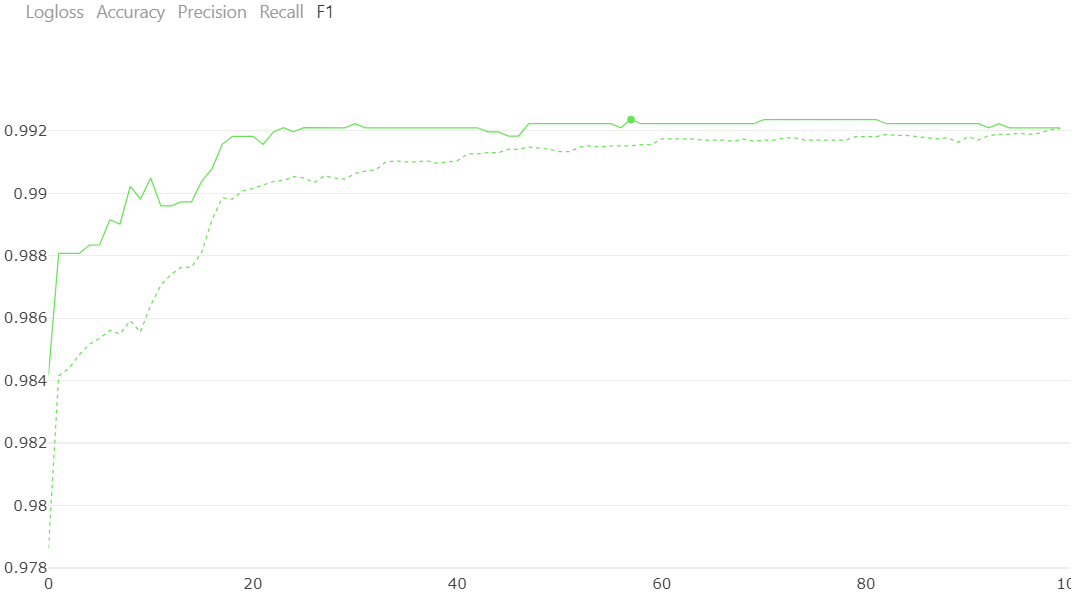

In [14]:
categorical_features_names = ['original', 'lenWord', 'wordForm', 'punktEnd', 'punktBeg', 'emphEnd', 'emphBeg', 'semantics1', 'semantics2',
                              'countBeforeWords', 'countAfterWords', 'beforeWords', 'afterWords', 'capitalized', 'indexInSentence', 
                              'subpartOfSpeech']
cls = Classifier(df_train=df, df_val=df_val, categorical_features=categorical_features_names, save_path='models/nucleus.cbm')

cls.fit(labels=df['nucleus_labels'], labels_val=df_val['nucleus_labels'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

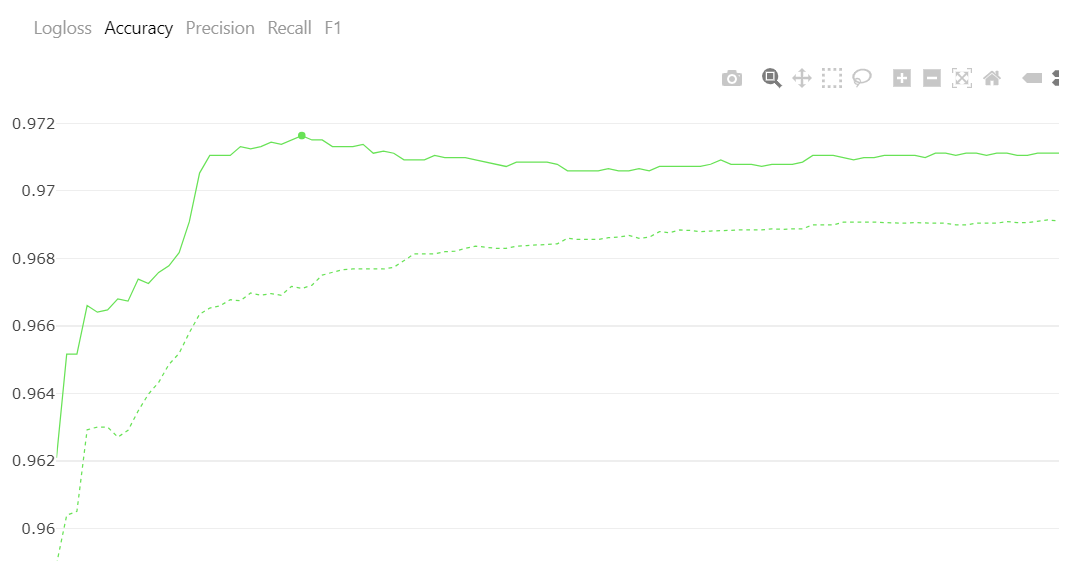
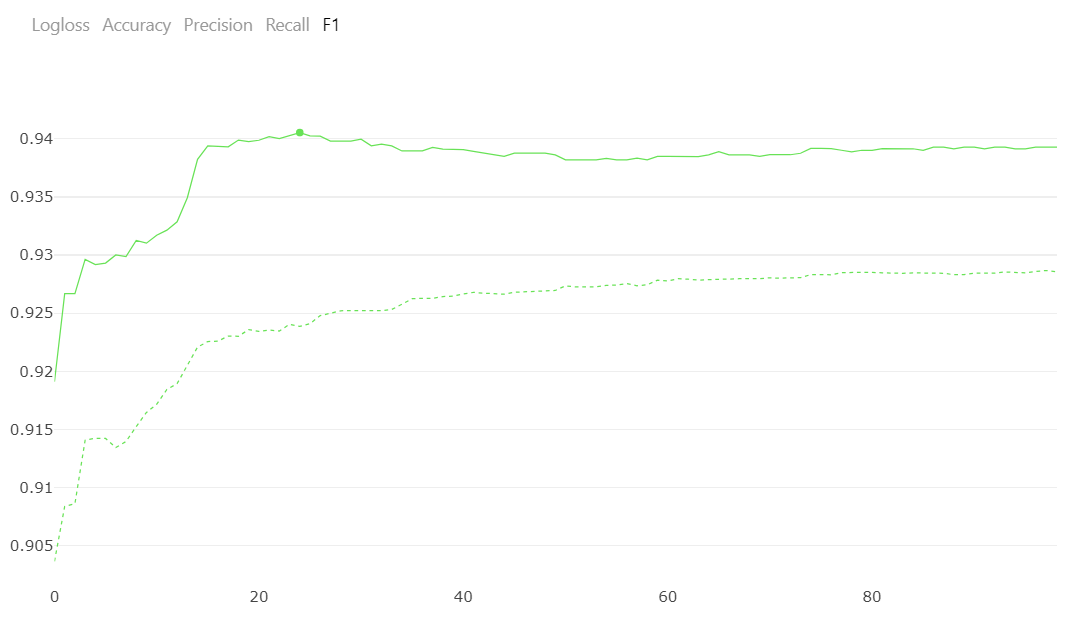

In [15]:
categorical_features_names = ['original', 'lenWord', 'wordForm', 'punktEnd', 'punktBeg', 'emphEnd', 'emphBeg', 'nucleus', 'semantics1', 
                              'semantics2', 'countBeforeWords', 'countAfterWords', 'beforeWords', 'afterWords', 'capitalized', 
                              'indexInSentence', 'subpartOfSpeech']

reg_df = df[df['lenPause'] != -1]
reg_df_val = df_val[df_val['lenPause'] != -1]
reg_df_cat = df_cat[df_cat['lenPause'] != -1]

reg = Regressor(df_train=reg_df, df_val=reg_df_val, categorical_features=categorical_features_names, save_path='models/lenPauses.cbm')

reg.fit(labels=reg_df['lenPause'], labels_val=reg_df_val['lenPause'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

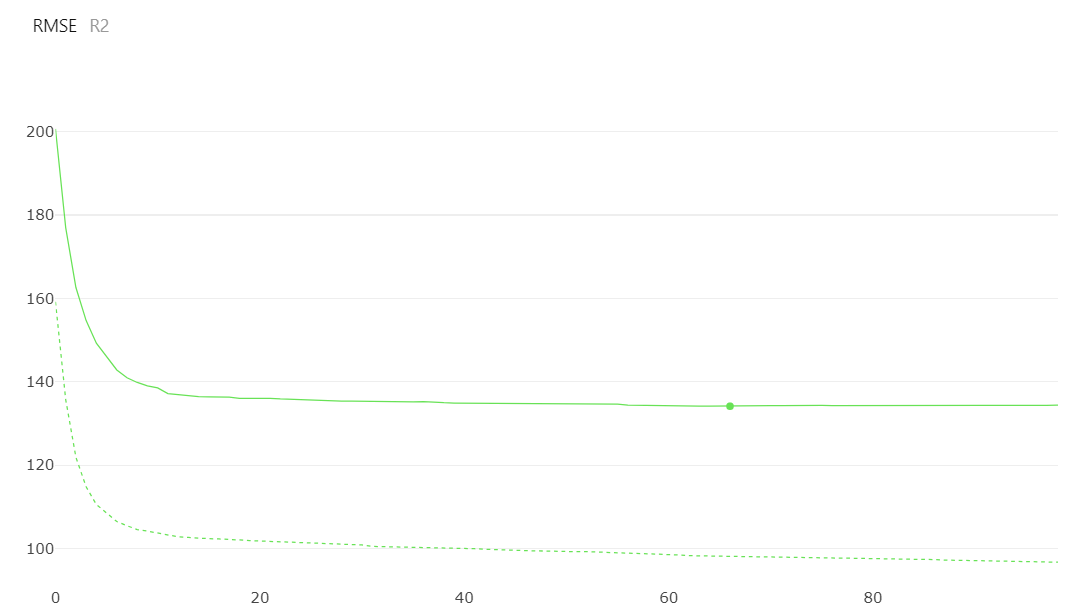
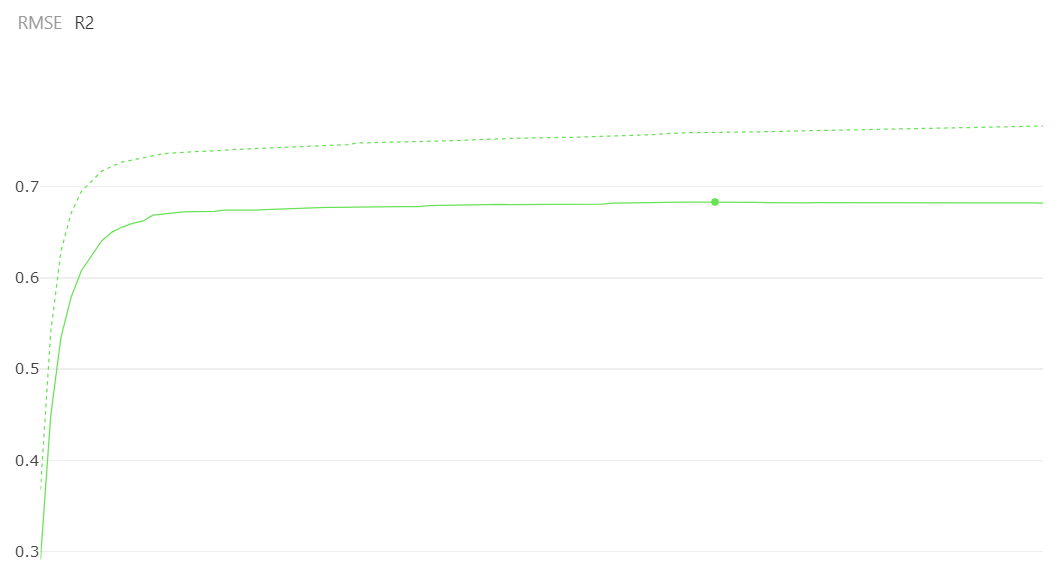

Функция для обучения всех моделей на всех возможных данных

In [18]:
def train_all(df: pd.DataFrame = None, df_val: pd.DataFrame = None) -> None:
    categorical_features_names = ['original', 'lenWord', 'wordForm', 'punktEnd', 'punktBeg', 'emphEnd', 'emphBeg', 'semantics1', 
                                  'semantics2', 'countBeforeWords', 'countAfterWords', 'beforeWords', 'afterWords', 'capitalized', 
                                  'indexInSentence', 'subpartOfSpeech']
    
    is_pause_cls = Classifier(df_train=df, df_val=df_val, categorical_features=categorical_features_names, save_path='models/isPause.cbm')
    is_pause_cls.fit(df['isPause'], df_val['isPause'])

    nucleus_cls = Classifier(df_train=df, df_val=df_val, categorical_features=categorical_features_names, save_path='models/nucleus.cbm')
    nucleus_cls.fit(df['nucleus_labels'], df_val['nucleus_labels'])

    reg_df = df[df['lenPause'] != -1]
    reg_df_val = df_val[df_val['lenPause'] != -1]

    len_pause_reg = Regressor(df_train=reg_df, df_val=reg_df_val, categorical_features=categorical_features_names, save_path='models/lenPauses.cbm')
    len_pause_reg.fit(reg_df['lenPause'], reg_df_val['lenPause'])

In [19]:
train_all(df=df_cat, df_val=df_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Тестирование

Функция для проведения тестирования

In [35]:
def test(filename: str = None) -> None:
    df = get_features(xml_filename=filename, csv_filename='test.csv')

    columns = ['original', 'lenWord', 'wordForm', 'punktEnd', 'punktBeg', 'emphEnd', 'emphBeg', 'semantics1', 'semantics2', 
               'countBeforeWords', 'countAfterWords', 'beforeWords', 'afterWords', 'capitalized', 'indexInSentence', 'subpartOfSpeech']

    pauses_cls = CatBoostClassifier()
    pauses_cls.load_model('models/isPause.cbm')
    places_of_pauses = pauses_cls.predict(df[columns])

    nucleus_cls = CatBoostClassifier()
    nucleus_cls.load_model('models/nucleus.cbm')
    places_of_nucleus = nucleus_cls.predict(df[columns])

    pauses_reg = CatBoostRegressor()
    pauses_reg.load_model('models/lenPauses.cbm')
    len_pauses = pauses_reg.predict(df[columns])

    result = {'words': []}

    for i, v in enumerate(df['original']):
        word = {}
        word['content'] = v
        word['phrasal_stress'] = True if places_of_nucleus[i] == 'True' else False
        word['pause_len'] = int(len_pauses[i]) if places_of_pauses[i] else -1
        result['words'].append(word)
    
    import json
    with open('test.json', mode='w+', encoding='utf-8') as file:
        json.dump([result], file, indent=4, ensure_ascii=False)
    


Вызов функции для тестирования и получения json файла. В аргументы пишется название файла разметки

In [36]:
test('data/fantasy1984.xml')